In [1]:
!pip install wordfreq
!pip install transformers
!pip install gensim

In [2]:
import numpy as np
import pandas as pd
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('words')
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import wordnet as wn
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.wsd import lesk
from transformers import BertModel, BertTokenizer, RobertaModel,RobertaTokenizer
from tqdm.auto import tqdm
from decimal import Decimal
from wordfreq import word_frequency,zipf_frequency
tqdm.pandas()
from nltk.wsd import lesk



[nltk_data] Downloading package wordnet to /home/ravi-pg/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/ravi-pg/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ravi-
[nltk_data]     pg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ravi-pg/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package words to /home/ravi-pg/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [3]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [4]:
import spacy
nlp=spacy.load('en_core_web_sm')

nlp.tokenizer=nlp.tokenizer.tokens_from_list
nltk_tokenizer = RegexpTokenizer(r'[a-zA-Z]+')


In [5]:
from torch.utils.data import DataLoader,Dataset
from sklearn.decomposition import PCA
from scipy.stats import pearsonr,spearmanr
evaluator0 = pearsonr
evaluator1 = spearmanr

In [6]:
if torch.cuda.is_available():
    device = "cuda:1"
else:
    device = "cpu"

print(f"using {device}")

using cuda:1


In [8]:
#Config params
class CFG():
  def __init__(self):
    self.batch_sz =256
    self.embed_dim = 4*768
    self.lr = 1e-5
    self.niter = 200
    self.alpha = 1
    self.feature_dim = 0
    self.dropout = 0.2
    self.classes = 10
    self.label_smooth = 0.1
    self.beta = 10
    self.w2v_dim = 250
cfg = CFG()    

In [8]:
from gensim.test.utils import datapath
from gensim import utils

class MyCorpus:
    """An iterator that yields sentences (lists of str)."""

    def __iter__(self):
        corpus_path = '../nlp_corpus.txt'
        for line in open(corpus_path):
            # assume there's one document per line, tokens separated by whitespace
            yield utils.simple_preprocess(line)

In [10]:
import gensim.models

## training Word2Vec
#sentences = MyCorpus()
#w2v_model = gensim.models.Word2Vec(sentences=sentences, vector_size=cfg.w2v_dim, window=35, min_count=2, workers=4)
#w2v_model.save("../saved_models/word2vec_250_35.model")

w2v_model = gensim.models.Word2Vec.load("../saved_models/word2vec.model")

In [14]:
def make_df(path):
    df = pd.DataFrame(columns=['id', 'corpus', 'sentence', 'token', 'complexity'])
    with open(path) as fd:
        lines = fd.readlines()
        print(len(lines))
        for i,row in tqdm(enumerate(lines[1:]),total=len(lines)):
          data = row.strip().split('\t')
          ent = {'id':data[0],'corpus':data[1],'sentence':data[2],'token':data[3],'complexity':float(data[4])}
          df.loc[i] = ent
    return df    

In [15]:
train_df = make_df("../train/lcp_single_train.tsv")
valid_df = make_df("../trial/lcp_single_trial.tsv")
test_df = make_df("../test-labels/lcp_single_test.tsv")

7663


KeyboardInterrupt: 

In [16]:
def syllable_count(word):
    word = word.lower()
    count = 0
    vowels = "aeiouy"
    if word[0] in vowels:
        count += 1
    for index in range(1, len(word)):
        if word[index] in vowels and word[index - 1] not in vowels:
            count += 1
    if word.endswith("e"):
        count -= 1
    if count == 0:
        count += 1
    return count

In [17]:
def get_feature_vector(sent,target1,target2):
    
    #---------------------------------------TARGET1--------------------------------------#
    #dependency parsing
    target_synsets = 0
    no_of_dep = 0
    dep_synset_avg = 0
    head_synset = 0
    syll_cnt = syllable_count(target1)
    nltk_tokens = nltk_tokenizer.tokenize(sent)
    for token in nlp(nltk_tokens):
        if token.text == target1:
            target_synsets = len(wn.synsets(target1))
            no_of_dep = len(list(token.children))
            head_synset = len(wn.synsets(token.head.text))
            if no_of_dep:
                for i in token.children:
                    dep_synset_avg += len(wn.synsets(i.text))
                dep_synset_avg /= no_of_dep
    
    
    #---------------------------------finding relative freq----------------------------#
    word_freq = word_frequency(target1, lang='en',wordlist = 'large', minimum=0.0)
    syn_freq = 0
    synset = lesk(sent, target1)
    synonym_list = None
    if synset is not None:
        synonym_list =synset.lemma_names()
    
    lb_freq = word_freq;ub_freq=word_freq
    
    if synonym_list!=None:
        for w in synonym_list:
            freq = word_frequency(w,lang='en',wordlist = 'large',minimum=0.0)
            lb_freq = min(lb_freq,freq)
            ub_freq = max(ub_freq,freq)
    
    rel_freq = np.exp(-(ub_freq-word_freq)/(ub_freq-lb_freq+ 1e-7))
    hypernym_sim =0 
    hyponym_sim = 0 
    wsd = lesk(sent, target1)
    cnt_0 =0 ;cnt_1=0
    if wsd:
        
        for hyper in wsd.hypernyms():
            cnt_0+=1
            hypernym_sim += wsd.wup_similarity(hyper)
        if cnt_0:
            hypernym_sim /= cnt_0
        
        for hypo in wsd.hyponyms():
            cnt_1+=1
            hyponym_sim += wsd.wup_similarity(hypo)
        if cnt_1:
            hyponym_sim /= cnt_1
        
    word_len = len(target1)/50
    lemmatized_len = (len(target1)-len(lemmatizer.lemmatize(target1)))/40
    try:
        wv = list(w2v_model.wv[target1])
    except KeyError:
        wv = [0]*cfg.w2v_dim
    feature_vec1 = cfg.alpha*torch.tensor(wv+
                                          [word_freq,
                                           #lb_freq,
                                           #ub_freq,
                                           syll_cnt,
                                           rel_freq,
                                           hypernym_sim,
                                           word_len,
                                           hyponym_sim,
                                           cnt_0,
                                           cnt_1,
                                           target_synsets,
                                           no_of_dep,
                                           dep_synset_avg,
                                           head_synset,
                                           lemmatized_len]).to(device)
    
    if target1==target2: return feature_vec1
    #----------------------------------------TARGET2----------------------------------------------#
    
    #dependency parsing
    target_synsets = 0
    no_of_dep = 0
    dep_synset_avg = 0
    head_synset = 0
    syll_cnt = syllable_count(target2)
    nltk_tokens = nltk_tokenizer.tokenize(sent)
    for token in nlp(nltk_tokens):
        if token.text == target2:
            target_synsets = len(wn.synsets(target2))
            no_of_dep = len(list(token.children))
            head_synset = len(wn.synsets(token.head.text))
            if no_of_dep:
                for i in token.children:
                    dep_synset_avg += len(wn.synsets(i.text))
                dep_synset_avg /=no_of_dep
    
    
    #---------------------------------finding relative freq----------------------------#
    word_freq = word_frequency(target2, lang='en',wordlist = 'large', minimum=0.0)
    syn_freq = 0
    synset = lesk(sent, target2)
    synonym_list = None
    if synset is not None:
        synonym_list =synset.lemma_names()
    
    lb_freq = word_freq;ub_freq=word_freq
    
    if synonym_list!=None:
        for w in synonym_list:
            freq = word_frequency(w,lang='en',wordlist = 'large',minimum=0.0)
            lb_freq = min(lb_freq,freq)
            ub_freq = max(ub_freq,freq)
    
    rel_freq = np.exp(-(ub_freq-word_freq)/(ub_freq-lb_freq+ 1e-7))
    hypernym_sim =0 
    hyponym_sim = 0 
    wsd = lesk(sent, target2)
    cnt_0 =0 ;cnt_1=0
    if wsd:
        
        for hyper in wsd.hypernyms():
            cnt_0+=1
            hypernym_sim += wsd.wup_similarity(hyper)
        if cnt_0:
            hypernym_sim /= cnt_0
        
        for hypo in wsd.hyponyms():
            cnt_1+=1
            hyponym_sim += wsd.wup_similarity(hypo)
        if cnt_1:
            hyponym_sim /= cnt_1
        
    word_len = len(target2)/50
    lemmatized_len = (len(target2)-len(lemmatizer.lemmatize(target2)))/40
    try:
        wv = list(w2v_model.wv[target2])
    except KeyError:
        wv = [0]*cfg.w2v_dim
    feature_vec2 = cfg.alpha*torch.tensor(wv+
                                          [word_freq,
                                           #lb_freq,
                                           #ub_freq,
                                           syll_cnt,
                                           rel_freq,
                                           hypernym_sim,
                                           word_len,
                                           hyponym_sim,
                                           cnt_0,
                                           cnt_1,
                                           target_synsets,
                                           no_of_dep,
                                           dep_synset_avg,
                                           head_synset,
                                           lemmatized_len]).to(device)
    
    
    final_emb = torch.cat((feature_vec1,feature_vec2),dim=0)
    return final_emb

In [19]:
class CustomDataset(Dataset):
  def __init__(self,df):
    self.data=[]
    ct = 0
    for i in tqdm(range(len(df))):
        try:
            target1 = df.loc[i]['token'].lower()
            target2 = df.loc[i]['token'].lower()

            emb = get_feature_vector(df.loc[i]['sentence'],target1,target2)
            complexity = torch.tensor(df.loc[i]['complexity']).to(device)
            self.data.append([emb,complexity])
        except KeyError:
            ct += 1
            continue
    print(ct)
  def __len__(self):
    return len(self.data)
  def __getitem__(self,idx):
    return self.data[idx][0],self.data[idx][1]

In [20]:
train_dataset1 = CustomDataset(train_df)
valid_dataset1 = CustomDataset(valid_df)
test_dataset1 = CustomDataset(test_df)

  0%|          | 0/7662 [00:00<?, ?it/s]

0


  0%|          | 0/421 [00:00<?, ?it/s]

0


  0%|          | 0/917 [00:00<?, ?it/s]

0


In [21]:
X_train = []
y_train = []
for b in train_dataset1:
    X_train.append(b[0].cpu().numpy())
    y_train.append(b[1].cpu().numpy())
X_train = np.array(X_train)
y_train = np.array(y_train)

X_valid = []
y_valid = []
for b in valid_dataset1:
    X_valid.append(b[0].cpu().numpy())
    y_valid.append(b[1].cpu().numpy())
X_valid = np.array(X_valid)    
y_valid = np.array(y_valid)

X_test = []
y_test = []
for b in test_dataset1:
    X_test.append(b[0].cpu().numpy())
    y_test.append(b[1].cpu().numpy())
X_test = np.array(X_test)    
y_test = np.array(y_test)

In [99]:
import xgboost as xg
from sklearn.svm import SVR
from tpot import TPOTRegressor
from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor,AdaBoostRegressor,StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
estimators = [('regr1',xg.XGBRegressor(n_estimators = 12, seed = 42)),
              ('regr2',AdaBoostRegressor(random_state=42)),
              ('regr3',GradientBoostingRegressor(random_state=42))]
#regr = StackingRegressor(estimators)
#regr = StackingRegressor(estimators)#GradientBoostingRegressor(random_state=42)
regr1 = GradientBoostingRegressor(random_state=42)
regr1.fit(X_train_norm,y_train)
#params = {'n_estimators':[50,100,200,300,400],'learning_rate':[1,2,4,6,8],'loss':['linear','exponential','square']}
#gs = GridSearchCV(regr,params)
#gs.fit(X_train_norm,y_train)


GradientBoostingRegressor(random_state=42)

In [100]:
preds1_v = regr.predict(scaler.transform(X_valid))
print('trial score for non-contextual:',evaluator0(preds1_v,y_valid))

(0.7678129236278173, 4.8481831286293006e-83)

In [101]:
preds1_t = regr.predict(scaler.transform(X_test))
print('test score for non-contextual:',evaluator0(preds1_t,y_test))

(0.7320292484046482, 1.1096089884198686e-154)

Bert Based Ordinal

In [30]:
def get_embedding_pipeline(sent,target1,target2,bert_tokenizer,model):
  nltk_tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
    
  nltk_tokens = nltk_tokenizer.tokenize(sent)
  word2berttokens = {}
  final_tokens = ['[CLS]']
  for token in nltk_tokens:
    tokenized_text = bert_tokenizer.tokenize(token)
    word2berttokens[token] = tokenized_text
    final_tokens += tokenized_text
  final_tokens += ['[SEP]']
  indexed_tokens = bert_tokenizer.convert_tokens_to_ids(final_tokens)
  tokens_tensor = torch.tensor([indexed_tokens]).to(device)
  tok2idx = dict(zip(final_tokens, list(range(len(indexed_tokens)))))
  model.eval()
  
  
  with torch.no_grad():
    outputs = model(tokens_tensor)
    hidden_state = outputs[2]
    word_embed= torch.cat([hidden_state[i] for  i in [-1,-2,-3,-4]],dim=-1)
      
  try: 
    target_word_tokenid1 = [tok2idx[i] for i in word2berttokens[target1]]
    target_word_tokenid2 = [tok2idx[i] for i in word2berttokens[target2]]
  except KeyError:
    return None
  embed1 = torch.zeros(cfg.embed_dim).to(device) ; embed2 = torch.zeros(cfg.embed_dim).to(device)
  for i in range(len(target_word_tokenid1)):
    embed1 = embed1 + word_embed[0,target_word_tokenid1[i]]
  embed1 /=len(target_word_tokenid1)
  if target1==target2: return embed1 
  for i in range(len(target_word_tokenid2)):
    embed2 = embed2 + word_embed[0,target_word_tokenid2[i]]
  embed2 /=len(target_word_tokenid2)
  return torch.cat((embed1,embed2),dim=0)

In [29]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertModel.from_pretrained('bert-base-cased',output_hidden_states=True)
model = model.to(device)

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [37]:
class CustomDataset2(Dataset):
  def __init__(self,df,tokenizer,model,istrain=False):
    self.df = df
    self.tokenizer = tokenizer
    self.model = model
    self.data=[]
    self.eye = torch.eye(cfg.classes)
    for i in tqdm(range(len(df))):
        t1 = self.df.loc[i]['token']#.strip().split(" ")[0]
        t2 = self.df.loc[i]['token']#.strip().split(" ")[1]
        emb = get_embedding_pipeline(self.df.loc[i]['sentence'],
                                     t1,
                                     t2,
                                     self.tokenizer,
                                     self.model)
        y_label = int((self.df.loc[i]['complexity']*(cfg.classes-1))//1)
        lower_tril = torch.tril(torch.ones(cfg.classes,cfg.classes))
        lower_tril = lower_tril[:-1]
        lower_tril = torch.cat([torch.zeros(1,lower_tril.size()[1]),lower_tril ],dim=0)
        lower_tril= lower_tril[:,:-1]
        y_label = lower_tril[y_label]
        
        if istrain:
            complexity = torch.tensor(y_label).to(device)
        else:
            complexity = torch.tensor(self.df.loc[i]['complexity']).to(device)
        if emb is None: 
            print("LOL")
            if istrain==False:
                emb = torch.zeros(cfg.embed_dim).to(device)
                self.data.append([emb,complexity])
            continue
        self.data.append([emb,complexity])

  def __len__(self):
    return len(self.data)
  def __getitem__(self,idx):
    return self.data[idx][0],self.data[idx][1]

In [38]:
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F

In [40]:
train_dataset = CustomDataset2(train_df,tokenizer,model,True)
valid_dataset = CustomDataset2(valid_df,tokenizer,model)

  0%|          | 0/7662 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


  0%|          | 0/421 [00:00<?, ?it/s]

In [41]:
train_dl = DataLoader(train_dataset,shuffle=True,batch_size=cfg.batch_sz)
valid_dl = DataLoader(valid_dataset,shuffle=False,batch_size=cfg.batch_sz)

In [43]:
class MLP(nn.Module):
  def __init__(self,input_sz,hidden_layers=[128,32,16],classes=5):
    super(MLP,self).__init__()
    self.layers = [input_sz]+hidden_layers+[classes]
    self.net = []
    for h0,h1 in zip(self.layers,self.layers[1:]):
      self.net.extend([nn.Linear(h0,h1),nn.ReLU(),nn.Dropout(cfg.dropout)])
    self.net.pop();self.net.pop()
    self.net.append(nn.Sigmoid())
    print(self.net)
    self.net = nn.Sequential(*self.net)
  def forward(self,x):
    y= self.net(x)
    return y

In [44]:
net = MLP(cfg.embed_dim ,[1024,512,256,32],cfg.classes-1)
net = net.double().to(device)
cfg.niter = 200

[Linear(in_features=3072, out_features=1024, bias=True), ReLU(), Dropout(p=0.2, inplace=False), Linear(in_features=1024, out_features=512, bias=True), ReLU(), Dropout(p=0.2, inplace=False), Linear(in_features=512, out_features=256, bias=True), ReLU(), Dropout(p=0.2, inplace=False), Linear(in_features=256, out_features=32, bias=True), ReLU(), Dropout(p=0.2, inplace=False), Linear(in_features=32, out_features=9, bias=True), Sigmoid()]


In [45]:
zero = torch.zeros(cfg.classes-1).to(device) 
for x,y in train_dl:
    zero += torch.sum(y,dim=0)

In [46]:
wt = []
cnt_zeros = 0
for i in range(cfg.classes - 1):
    if zero[i].item() != 0:
        wt.append(1)
    else:
        wt.append(0)
        cnt_zeros+=1
        

In [47]:
optimizer = optim.Adam(net.parameters(), lr=cfg.lr)
criterion1 = nn.MSELoss()
criterion = nn.BCELoss(weight = torch.tensor(wt).to(device))

In [48]:
def train(epoch, dataloader, net, criterion, optimizer, cfg , loss_arr, scheduler=None):
  net.train()
  for i,(x,y) in enumerate(dataloader):
    x=x.double().to(device);y=y.double().to(device)
    optimizer.zero_grad()
    outp=net(x)
    #outp = outp/ordinal_threshold
    #outp = mask*outp
    loss = criterion(outp,y)
    loss.backward()
    optimizer.step()
    if scheduler:
        scheduler.step()
    if i % 10 == 0:
        loss_arr.append(loss.item()/cfg.batch_sz)

In [49]:
def valid(epoch, dataloader, net, criterion, optimizer, cfg):
  total_loss = 0.
  pearson_loss = 0
  net.eval()
  soft = nn.Softmax(dim=1)
  for i,(x,y) in enumerate(dataloader):
    with torch.no_grad():
      x=x.double().to(device);y=y.double().to(device)
      outp=net(x)
      #mask = outp>ordinal_threshold
      #outp = outp*mask  
      outp1 = torch.sum(outp[:,:-cnt_zeros],dim=1)
      
      outp1/=(cfg.classes-1)
      total_loss += criterion(outp1,y)
      pearson_loss += evaluator0(outp1.flatten().tolist(),y.flatten().tolist())[0]

  total_loss /= len(dataloader.dataset)
  pearson_loss/=len(dataloader)
  return total_loss,pearson_loss


In [50]:
pearson_best=-1
loss_arr = [];pearson_arr = []
for epoch in tqdm(range(0, cfg.niter)):
    train(epoch, train_dl, net, criterion, optimizer,cfg,[])
    (loss,pearson)=valid(epoch, valid_dl, net, criterion1, optimizer, cfg)
    loss_arr.append(loss)
    pearson_arr.append(pearson)
    if pearson_best<pearson:
        pearson_best=pearson
        torch.save({'model':net.state_dict(),'optimizer':optimizer.state_dict()},"../saved_models/best_model")

  0%|          | 0/200 [00:00<?, ?it/s]

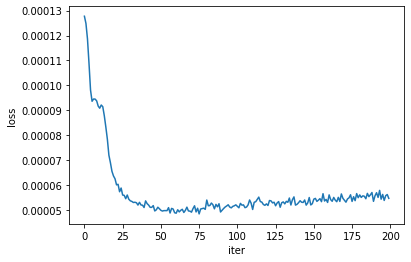

In [51]:
from matplotlib import pyplot as plt
plt.plot(loss_arr)
plt.xlabel('iter')
plt.ylabel('loss')
plt.show()

## Testing

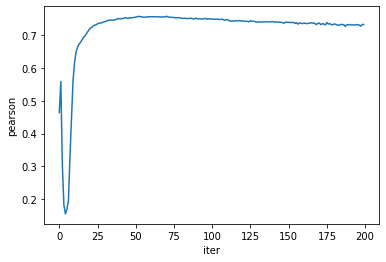

In [52]:
from matplotlib import pyplot as plt
plt.plot(pearson_arr)
plt.xlabel('iter')
plt.ylabel('pearson')
plt.show()

In [53]:
pearson_best

0.7572061905090648

In [54]:
states= torch.load('../saved_models/best_model')

In [55]:
net.load_state_dict(states['model'])

<All keys matched successfully>

In [56]:
test_dataset = CustomDataset2(test_df,tokenizer,model)
test_dl = DataLoader(test_dataset,shuffle=False,batch_size=cfg.batch_sz)
ordinal_threshold = 0.5

  0%|          | 0/917 [00:00<?, ?it/s]

LOL


In [131]:
ordinal_threshold = 0.725

In [132]:
def test(dataloader, net, criterion, optimizer, cfg):
    net.eval()
    pred=[]
    gts=[]
    soft = nn.Softmax(dim=1)
    for i,(x,y) in enumerate(dataloader):
        with torch.no_grad():
            x=x.double().to(device);y=y.double().to(device)
            outp=net(x)
#             outp = soft(outp)
            mask = outp>ordinal_threshold
            outp = mask*outp
            print(outp[0])
            outp1 = torch.sum(outp[:,:-cnt_zeros],dim=1)
            outp1/=(cfg.classes-1)
            print(outp1[0])
            pred.extend(outp1.tolist())
            gts.extend(y.tolist())
    return pred,gts

In [133]:
preds2_v,gts = test(valid_dl,net,criterion,optimizer,cfg)
best_f = 0
best_p_c = -1
for f in np.arange(0,1,0.05):
    print("-----------\n",f)
    preds1_n_v = preds1_v * (f)
    preds2_n_v = np.array(preds2_v) * (1-f)
    cpc = evaluator0((preds2_n_v+preds1_n_v),gts)[0]
    print(cpc)
    if cpc > best_p_c:
        best_p_c = cpc
        best_f = f
    

tensor([0.9472, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0', dtype=torch.float64)
tensor(0.1052, device='cuda:0', dtype=torch.float64)
tensor([0.9658, 0.9810, 0.9290, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0', dtype=torch.float64)
tensor(0.3195, device='cuda:0', dtype=torch.float64)
-----------
 0.0
0.7387025762957424
-----------
 0.05
0.7473141995486757
-----------
 0.1
0.7554055295075373
-----------
 0.15000000000000002
0.7629170115374386
-----------
 0.2
0.7697907411518327
-----------
 0.25
0.7759716128032192
-----------
 0.30000000000000004
0.7814085014210423
-----------
 0.35000000000000003
0.7860554326185417
-----------
 0.4
0.7898726929801416
-----------
 0.45
0.792827830304098
-----------
 0.5
0.7948964956324388
-----------
 0.55
0.7960630845411971
-----------
 0.6000000000000001
0.7963211442780923
-----------
 0.65
0.7956735252999897
-----------
 0.7000000000000001
0.7941322695989831
-----------
 0.75
0.

In [134]:
print(best_f,'...',best_p_c)

0.6000000000000001 ... 0.7963211442780923


In [135]:
preds2_t,gts = test(test_dl,net,criterion,optimizer,cfg)
f = best_f
preds1_n_t = preds1_t * (f)
preds2_n_t = np.array(preds2_t) * (1-f)
print(evaluator0((preds2_n_t+preds1_n_t),gts))
print(evaluator1((preds2_n_t+preds1_n_t),gts))

tensor([0.9255, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0', dtype=torch.float64)
tensor(0.1028, device='cuda:0', dtype=torch.float64)
tensor([0.9765, 0.9859, 0.9298, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0', dtype=torch.float64)
tensor(0.3214, device='cuda:0', dtype=torch.float64)
tensor([0.9651, 0.9021, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0', dtype=torch.float64)
tensor(0.2075, device='cuda:0', dtype=torch.float64)
tensor([0.9757, 0.8124, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0', dtype=torch.float64)
tensor(0.1987, device='cuda:0', dtype=torch.float64)
(0.7599379974433524, 2.2542364381792984e-173)
SpearmanrResult(correlation=0.7196134579179357, pvalue=4.188723563972491e-147)


In [115]:
sub_df = pd.DataFrame(columns = ['id','score'])
f = best_f
preds1_n_v = preds1_v * (f)
preds2_n_v = np.array(preds2_v) * (1-f)
sub_df['id'] = valid_df['id']
sub_df['score'] = preds1_n_v + preds2_n_v
sub_df.head()

,id,score
0,3QI9WAYOGQB8GQIR4MDIEF0D2RLS67,0.146066
1,3T8DUCXY0N6WD9X4RTLK8UN1U929TF,0.145426
2,3I7KR83SNADXAQ7HXK7S7305BYB9KD,0.146696
3,3BO3NEOQM0HK9ERYPN0GQIWCPC4IAQ,0.145061
4,3Y3CZJSZ9KT0W7I0KE38WZHHKSW5RH,0.147508


In [116]:
sub_df.to_csv('../outputs/single_final_valid_ensemble_thresh-0.725_concat_10class.csv',header=None,index=False,encoding='utf-8')

In [117]:
sub_df = pd.DataFrame(columns = ['id','score'])
f = best_f
preds1_n_t = preds1_t * (f)
preds2_n_t = np.array(preds2_t) * (1-f)
sub_df['id'] = test_df['id']
sub_df['score'] = preds1_n_t + preds2_n_t
sub_df.head()

,id,score
0,3K8CQCU3KE19US5SN890DFPK3SANWR,0.152763
1,3Q2T3FD0ON86LCI41NJYV3PN0BW3MV,0.159093
2,3ULIZ0H1VA5C32JJMKOTQ8Z4GUS51B,0.154279
3,3BFF0DJK8XCEIOT30ZLBPPSRMZQTSD,0.154339
4,3QREJ3J433XSBS8QMHAICCR0BQ1LKR,0.190026


In [118]:
sub_df.to_csv('../outputs/single_final_test_ensemble_thresh-0.725_concat_10class.csv',header=None,index=False,encoding='utf-8')